# Import and Define

In [1]:
from plot import *
import numpy as np
import pandas as pd
import polars as pl
from huggingface_hub import hf_hub_download, snapshot_download

from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()

/accounts/grad/czye/conda/envs/gpn_env/envs/gpn_star/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
palette = {
    'GPN-Star': "#2773BA",
    'PhyloP': '#9E66BA', 
    'PhastCons': '#C4494B',
}

In [3]:
# model groups

gpn_star_models = [
    'GPN-Star'
]

genome_wide_veps = [
    'PhyloP',
    'PhastCons',
]

In [4]:
WORK_DIR = 'tmp/'

# DEST rare vs. common enrichment

In [5]:
snapshot_download(repo_id="songlab/dest", local_dir=f"{WORK_DIR}/dest", repo_type="dataset")

Fetching 6 files: 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/tmp/dest'

In [6]:
V_dest = pd.read_parquet(f'{WORK_DIR}/dest/test.parquet')

all_models = genome_wide_veps + gpn_star_models
for m in all_models:
    V_dest[m] = pd.read_parquet(f'{WORK_DIR}/dest/predictions/{m}.parquet')

In [7]:
V_dest = pl.from_pandas(V_dest) # compute in polars for efficiency
V_dest

chrom,pos,ref,alt,AF,consequence,label,PhyloP,PhastCons,GPN-Star
str,i64,str,str,f64,str,bool,f64,f64,f64
"""2L""",5762,"""T""","""C""",0.298266,"""intergenic""",false,null,null,0.995839
"""2L""",6353,"""C""","""T""",0.563833,"""intergenic""",false,0.439,0.992,0.684266
"""2L""",6631,"""A""","""G""",0.262617,"""upstream_gene""",false,-0.619,0.041,0.629686
"""2L""",6690,"""C""","""G""",0.220744,"""upstream_gene""",false,-1.026,0.003,1.430253
"""2L""",6921,"""G""","""T""",0.252886,"""upstream_gene""",false,0.227,0.988,0.67003
…,…,…,…,…,…,…,…,…,…
"""Y""",3657159,"""A""","""G""",0.337791,"""intron""",false,1.545,0.002,2.160893
"""Y""",3657194,"""A""","""T""",0.329693,"""intron""",false,-0.617,0.0,3.15511
"""Y""",3657203,"""A""","""C""",0.33839,"""intron""",false,-3.541,0.0,1.635296


In [8]:
results_dest = []
for c in tqdm(V_dest['consequence'].unique().to_list()+['all']):
    if c != 'all' and (V_dest['consequence']==c).sum() < 500:
        continue
    df_c = V_dest.clone() if c == "all" else V_dest.filter(pl.col("consequence") == c)
    df_c = df_c.drop_nulls(subset=all_models)
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in all_models:
        try:
            if m not in gpn_star_models:
                # Fix: Apply negation to the score column instead of the DataFrame
                selected_df = df_c.select(["label", pl.col(m).alias("score")])
                selected_df = selected_df.with_columns(pl.col("score") * -1)
                odds_ratio = (
                    get_odds_ratio(selected_df, [30])
                    .with_columns(
                        Consequence=pl.lit(c), Model=pl.lit(m),
                        n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
                    )
                )
                results_dest.append(odds_ratio)
            else:
                odds_ratio = (
                    get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30])
                    .with_columns(
                        Consequence=pl.lit(c), Model=pl.lit(m),
                        n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
                    )
                )
                results_dest.append(odds_ratio)
        except:
            pass

results_dest = pl.concat(results_dest).to_pandas()
results_dest.head()

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 44.31it/s]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,2.998124,4.079891e-07,non_coding_transcript_exon,PhyloP,7828,12930
1,30,3.537205,8.681643e-266,non_coding_transcript_exon,PhastCons,7828,12930
2,30,34.291161,5.266599e-213,non_coding_transcript_exon,GPN-Star,7828,12930
3,30,2.379200,2.397734e-03,synonymous,PhyloP,28700,100756
4,30,1.123226,7.344716e-11,synonymous,PhastCons,28700,100756


In [10]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "splice_region": "splice-region",
    "start_or_stop": "start-or-stop",
}
results_dest['Consequence'] = results_dest['Consequence'].replace(replacements)

In [11]:
results_dest = results_dest.sort_values('Odds ratio', ascending = False)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:414: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(


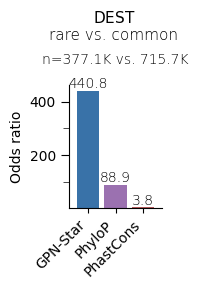

In [13]:
barplot_vertical(
    results_dest[
        (results_dest.p_value < 0.05) &
        (results_dest.Consequence == "all")
    ],
    "Odds ratio",
    r"$\bf{\sf{DEST}}$" + "\nrare vs. common",
    y=1.35, width=1.2, height=1.6,
    palette=palette,
)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette`

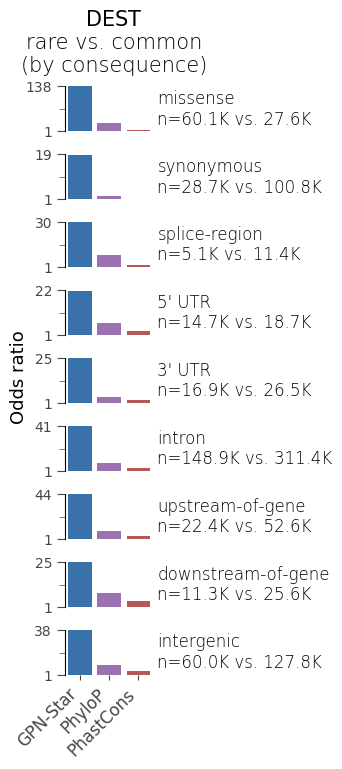

In [14]:
barplot_vertical_aligned(
    results_dest[(results_dest.n==30) & (results_dest.p_value < 0.05)],
    metric="Odds ratio",
    title=r"$\bf{\sf{DEST}}$" + "\nrare vs. common\n(by consequence)",
    palette=palette,
    width=1.3,
    height=0.85,
    hspace=0.5,
    suptitle_y=0.98,
    model_order=['GPN-Star', 'PhyloP', 'PhastCons',],
    group_order=['missense', 'synonymous', 'splice-region', "5' UTR", "3' UTR", 'intron', 'upstream-of-gene', 'downstream-of-gene', 'intergenic'],
)


# Flybase lethal

In [15]:
snapshot_download(repo_id="songlab/flybase_lethal", local_dir=f"{WORK_DIR}/flybase", repo_type="dataset")

Fetching 6 files: 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/tmp/flybase'

In [16]:
V_flybase = pd.read_parquet(f'{WORK_DIR}/flybase/test.parquet')

for m in genome_wide_veps + gpn_star_models:
    V_flybase[m] = pd.read_parquet(f'{WORK_DIR}/flybase/predictions/{m}.parquet')
V_flybase

,chrom,pos,ref,alt,consequence,label,PhyloP,PhastCons,GPN-Star
0,3L,12736453,T,A,missense,True,12.841,1.000,-7.734124
1,2L,8301571,C,T,nonsense,True,20.000,1.000,-9.068040
2,2L,6971200,C,T,nonsense,True,20.000,1.000,-10.436153
3,2R,9403730,G,A,nonsense,True,5.671,1.000,-8.753520
4,2R,7280291,C,T,nonsense,True,1.808,0.020,-7.069754
...,...,...,...,...,...,...,...,...,...
39144,Y,3253257,C,A,missense,False,0.015,0.007,1.472105
39145,Y,3253332,T,A,missense,False,NaN,NaN,1.399647
39146,Y,3289942,C,A,missense,False,0.569,0.986,-1.555449
39147,Y,3289964,A,C,missense,False,-0.539,0.000,2.582490


In [17]:
all_models = genome_wide_veps + gpn_star_models
rows = []
V_flybase_c = V_flybase.copy()
V_flybase_c.dropna(subset=all_models, inplace=True)
V_flybase_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_flybase_c.label==True).sum(), (V_flybase_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(all_models, desc='models'):
    if m in gpn_star_models:
        AUROC = roc_auc_score(V_flybase_c.label==True, -V_flybase_c[m])
        AUPRC = average_precision_score(V_flybase_c.label==True, -V_flybase_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_flybase_c.label==True, -V_flybase_c[m])
    else:
        AUROC = roc_auc_score(V_flybase_c.label==True, V_flybase_c[m])
        AUPRC = average_precision_score(V_flybase_c.label==True, V_flybase_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_flybase_c.label==True, V_flybase_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 3/3 [00:48<00:00, 16.28s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
2,GPN-Star,0.984074,0.928743,0.001337,0.003672
0,PhyloP,0.933700,0.685252,0.002680,0.008351
1,PhastCons,0.892218,0.315794,0.002654,0.003613


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


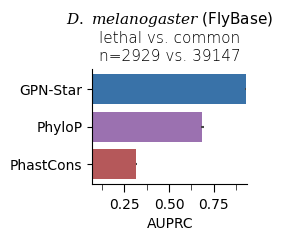

In [19]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,1.5),
    title = r'$\it{D.\ melanogaster\ }\bf{\sf{(FlyBase)}}$' + f"\nlethal vs. common\nn={n_pos} vs. {n_neg}",
)